In [42]:
from keras import backend as K
import time
from keras.layers.merge import add

import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,AveragePooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.layers import Conv2D, Input
from keras.optimizers import SGD
import keras
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2


import tensorflow as tf

import random
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


dir="/content/gdrive/My Drive/Colab Notebooks/eva2/ass13/"
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
batch_size = 128

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()



In [14]:
train_features.shape

(50000, 32, 32, 3)

In [0]:
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

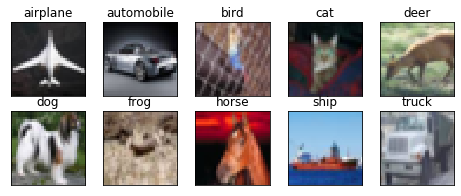

In [16]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Standardization of image using provided mu and sigma 

In [0]:
mu = np.array([0.4914, 0.4822, 0.4465]) 
sigma = np.array([0.2023, 0.1994, 0.2010])

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# standardization of images
train_features = (train_features-mu)/sigma
test_features = (test_features-mu)/sigma

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Functions for callbacks and visualizations

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


def cut_out_function(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
 
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        input_img[top:top + h, left:left + w, :] = mu
        
        return input_img

    return eraser



class CyclicLR(Callback):
    

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


# def randomCrop(padding, height = 32, width = 32):
#   def crop(img):
#     input_img = np.pad(img, padding)[:,:,padding:padding+3]
#     #height = img.shape[0]
#     #width = img.shape[1]
#     x = random.randint(0, img.shape[1] - width)
#     y = random.randint(0, img.shape[0] - height)
#     img = img[y:y+height, x:x+width]
#     return img
#   return crop



# def scheduler(epoch, lr):
#   return round(0.04 * 1/(1 + 0.055 * epoch), 10)

## Preprocessed data generation

In [0]:
# width_shift_range parameter perform random cropping by shifting them image by a fraction of width
datagen_train = ImageDataGenerator(width_shift_range = 0.125,
                             height_shift_range = 0.125,
                             horizontal_flip=True, 
                             preprocessing_function = cut_out_function())

datagen_test = ImageDataGenerator()

train_gen = datagen_train.flow(train_features, train_labels, batch_size = batch_size, shuffle=True)
valid_gen = datagen_test.flow(test_features, test_labels, batch_size = int(test_features.shape[0]/5), shuffle = True)



## Verifiying the processed data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

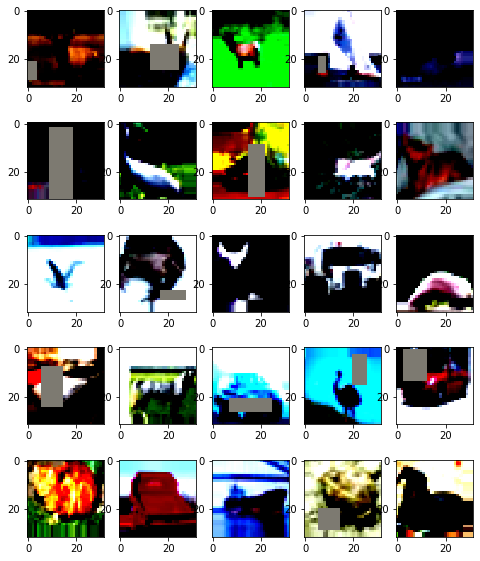

In [56]:
x,y = next(train_gen)
fig = plt.figure(figsize=(8, 10))
for i in range(25):
    sub = fig.add_subplot(5, 5, i + 1)
    sub.imshow(x[i])





In [0]:
## Building Resnet model

In [0]:
ROW_AXIS = 1
COL_AXIS = 2
CHANNEL_AXIS = 3


def bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return bn_relu(conv)

    return f


def bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def residual_block(filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = basic_block(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return shortcut(input, residual)

    return f


def get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier



def Resnet_builder(input_shape, num_outputs, repetitions):
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    input = Input(shape=input_shape)
    conv1 = conv_bn_relu(filters=32, kernel_size=(3, 3), strides=(1, 1))(input)
    #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
    block = conv1
    filters = 64
    for i, r in enumerate(repetitions):
        block = residual_block(filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
        filters *= 2

    # Last activation
    block = bn_relu(block)

    # Classifier block
    block_shape = K.int_shape(block)
    pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                              strides=(1, 1))(block)
    flatten1 = Flatten()(pool2)
    dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                  activation="softmax")(flatten1)

    model = Model(inputs=input, outputs=dense)
    return model

    




## Final function for building RESNET architecture

In [0]:
def build_resnet(input_shape, num_outputs, repetitions):
      
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_rows, nb_cols, nb_channels)")
            
        input = Input(shape=(input_shape[0], input_shape[1], input_shape[2],))
        init_filters = 16
        
        conv1 = conv_bn_relu(input, filters=init_filters, kernel_size=(3, 3), strides=(1,1))
        #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
        
        block = conv1
        filters = init_filters * 2
        for i, r in enumerate(repetitions):
            block = residual_block(filters=filters, repetitions=r, is_first_block=(i == 0))(block)
            #print(i, " RESIDUAL BLOCK END ", block.shape)
            filters *= 2

        # Last activation
        block = bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        #print("Average pool shape", pool2.shape)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

In [52]:
model = Resnet_builder((32,32,3), 10, [2, 2, 2, 2])
model.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 32, 32, 32)   128         conv2d_56[0][0]                  
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 32, 32, 32)   0           batch_normalization_43[0][0]     
____________________________________________________________________________________________

## Models pictorial representation

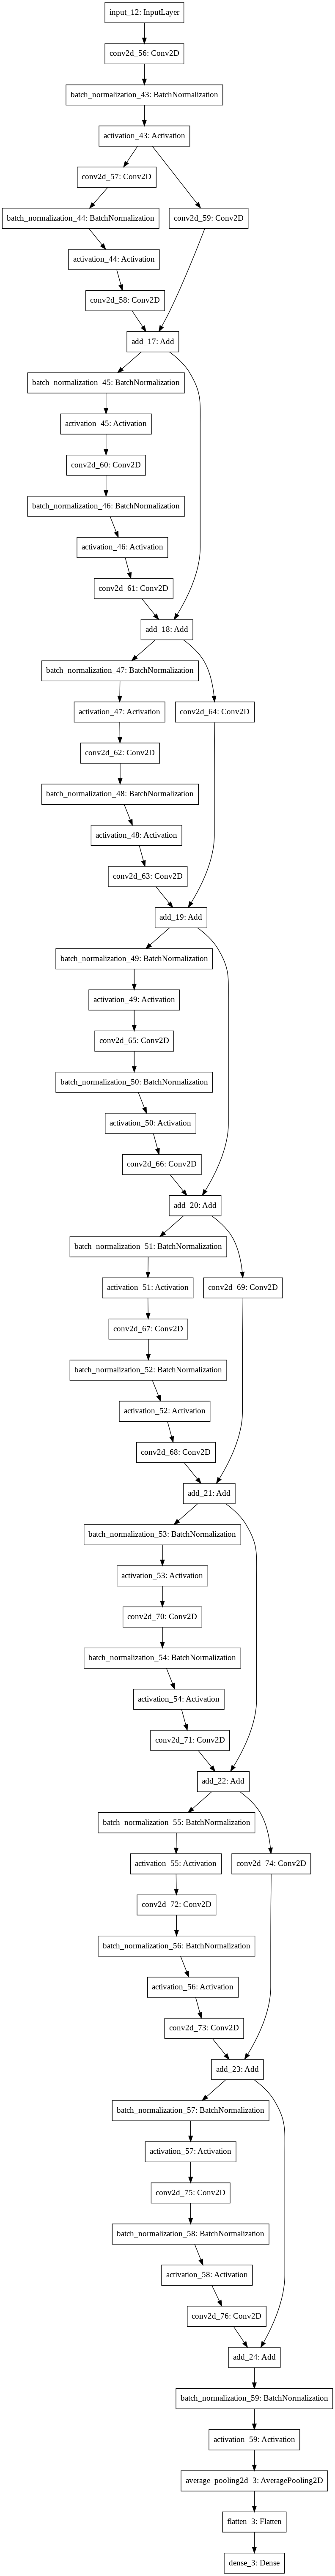

In [55]:
plot_model(model, to_file='model.png')

## Model reached and accuracy of 87% in 135th epoc.
- there is a scope to increase accuracy further as the training accuracy is still 92.
- I will push the model further in future submissions

In [54]:
file = dir + "Weights/Assign13_normal.{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(train_gen,samples_per_epoch = train_features.shape[0], nb_epoch = 160, 
                                 validation_data = valid_gen, verbose=1, callbacks = [CyclicLR(base_lr = 0.001, max_lr = 0.006, step_size=2000,mode = "triangular2"), checkpoint])
# LearningRateScheduler(scheduler, verbose=1)  CyclicLR(base_lr=5e-4, max_lr=5e-2, step_size=2000., mode='triangular2')
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))#76 rf 40


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=300)`
  if __name__ == '__main__':


Epoch 1/300
390/390 [==============================] - 120s 306ms/step - loss: 2.9117 - acc: 0.2923 - val_loss: 2.6843 - val_acc: 0.3763

Epoch 00001: val_acc improved from -inf to 0.37630, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2/ass13/Weights/Assign13_normal.001-0.3763.hdf5
Epoch 2/300
390/390 [==============================] - 111s 285ms/step - loss: 2.6016 - acc: 0.4022 - val_loss: 2.4874 - val_acc: 0.4441

Epoch 00002: val_acc improved from 0.37630 to 0.44410, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2/ass13/Weights/Assign13_normal.002-0.4441.hdf5
Epoch 3/300
390/390 [==============================] - 111s 286ms/step - loss: 2.4386 - acc: 0.4646 - val_loss: 2.3815 - val_acc: 0.4732

Epoch 00003: val_acc improved from 0.44410 to 0.47320, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2/ass13/Weights/Assign13_normal.003-0.4732.hdf5
Epoch 4/300
390/390 [==============================] - 111s 285ms/step - loss: 2.3118 - acc: 0.5073 